# Experiments with Fitzpatrick17K

To avoid further confusion by libraries' dependency, we resized the image's height from 450 and width from 600 to 300 and 300 pixels, respectively.

In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

import imageprocessing
from imageprocessing import ImageResize, MaskedImage
from kerasmodels import CreateGenerator, CNNModel
import attacks
from skincolors import IndividualTypologyAngle
from distance import DistanceMeasure

2024-07-21 07:53:34.186046: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 07:53:34.212845: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-21 07:53:34.735571: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load data

In [2]:
db = "FITZ"
root = f"../../dataset/IEEE/{db}/"

train_df = pd.read_csv(f"{root}exp/train_df.csv")
valid_df = pd.read_csv(f"{root}exp/valid_df.csv")
test_df = pd.read_csv(f"{root}exp/test_df.csv")

In [3]:
train_df["labels"] = train_df["labels"].astype(str)
valid_df["labels"] = valid_df["labels"].astype(str)
test_df["labels"] = test_df["labels"].astype(str)

## Create image generator

In [4]:
sample_image_path = train_df["filepath"].iloc[0]
img_size = imageprocessing.get_image_size(sample_image_path)
print("H*W: ", img_size)

H*W:  (300, 300)


In [5]:
batch_size=8
img_size = img_size
cg = CreateGenerator(img_size, batch_size)
train_gen = cg.train_generator(train_df)
valid_gen = cg.valid_generator(valid_df)
test_gen = cg.valid_generator(test_df)

Found 2000 validated image filenames belonging to 2 classes.
Found 864 validated image filenames belonging to 2 classes.
Found 864 validated image filenames belonging to 2 classes.


## Training

In [6]:
import torch # Due to keras version
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import keras

keras.utils.set_random_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=[300, 300, 3]))
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
        
model.add(keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
        
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
        
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=32, activation="relu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.L1L2()))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=1, activation="sigmoid", kernel_initializer="glorot_uniform", name="classifier"))
        
model.compile(Adam(learning_rate= 0.0001), loss= "binary_crossentropy", metrics= ["accuracy"])
model.summary()

2024-07-21 07:53:35.412230: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 07:53:35.413034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 07:53:35.413059: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 07:53:35.415613: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 07:53:35.415644: I external/local_xla/xla/stream_executor

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 300, 300, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 175232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     5,607,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,886,273 (22.45 MB)

 Trainable params: 5,885,761 (22.45 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/20


/home/kuniko/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1721544819.465874  750934 service.cc:145] XLA service 0x7fa99c013da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721544819.465929  750934 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-07-21 07:53:39.499826: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-21 07:53:39.670641: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


  5/250 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.2325 - loss: 1.3489 

I0000 00:00:1721544821.933074  750934 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.5405 - loss: 0.8107 - val_accuracy: 0.5648 - val_loss: 0.7052
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.6059 - loss: 0.6962 - val_accuracy: 0.5880 - val_loss: 0.8764
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.6278 - loss: 0.6667 - val_accuracy: 0.5799 - val_loss: 0.9289
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.6083 - loss: 0.6686 - val_accuracy: 0.5995 - val_loss: 0.8641
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.6466 - loss: 0.6345 - val_accuracy: 0.5706 - val_loss: 0.9577
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.6487 - loss: 0.6229 - val_accuracy: 0.6111 - val_loss: 0.7294


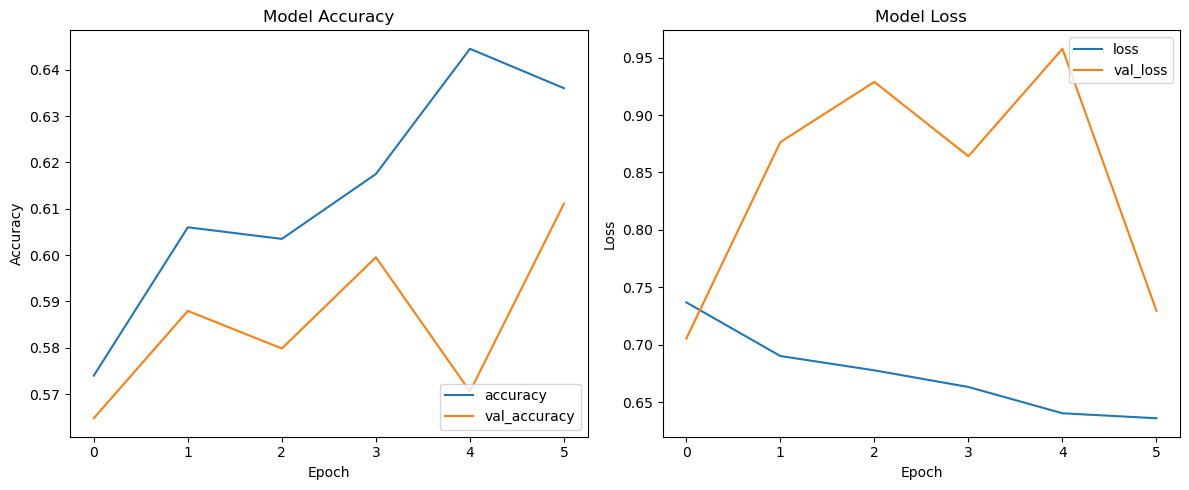

In [7]:
epochs = 20
callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=[callback])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax[0].plot(history.history["accuracy"], label="accuracy")
ax[0].plot(history.history["val_accuracy"], label="val_accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc="lower right")
ax[0].set_title("Model Accuracy")

# Loss
ax[1].plot(history.history["loss"], label="loss")
ax[1].plot(history.history["val_loss"], label="val_loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="upper right")
ax[1].set_title("Model Loss")

plt.tight_layout()
plt.show()

## Evaluation

In [8]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Loss", test_loss)
print("Test Accuracy", test_acc)
pred = model.predict(test_gen, verbose=0)
pred_class = ["1" if p[0] >= 0.5 else "0" for p in pred]

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5614 - loss: 0.7085
Test Loss 0.7027676105499268
Test Accuracy 0.5601851940155029


In [9]:
test_df["pred"] = pred_class
print(classification_report(test_df["labels"], test_df["pred"]))

              precision    recall  f1-score   support

           0       0.59      0.41      0.48       432
           1       0.55      0.71      0.62       432

    accuracy                           0.56       864
   macro avg       0.57      0.56      0.55       864
weighted avg       0.57      0.56      0.55       864



# Adversarial attacks

## Random Noise

True label: 1
Prediction: [[0.75748]]
Prediction class: ['1']
Adversarial Prediction: [[0.6702296]]
Adversarial Predicted Class: ['1']


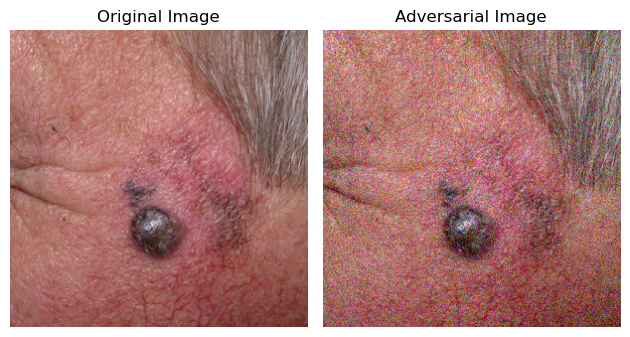

In [10]:
np.random.seed(42)
filepath = f"{root}data/ede3cf4179d6e3de2764edecc494c118.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.16
attacks.random_noise_attack_with_image(model, filepath, true_label, eps)

In [11]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.random_noise_attack(model, d["filepath"], d["labels"], eps))

In [12]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["RN pred"] = adv_pred
test_df["RN pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "RN")

RN Success rate: 0.10648148148148148
RN TN Success rate: 0.06481481481481481
RN FP Success rate: 0.041666666666666664


## FGSM

True label: 1
Prediction: [[0.75748]]
Prediction class: ['1']
Adversarial Prediction: [[0.25270355]]
Adversarial Predicted Class: ['0']


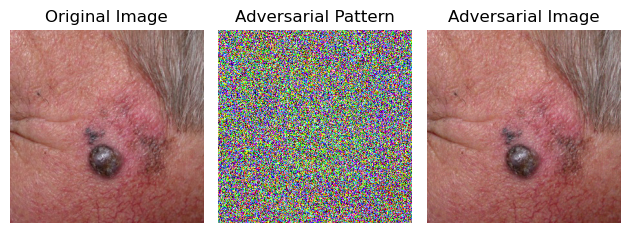

In [13]:
filepath = f"{root}data/ede3cf4179d6e3de2764edecc494c118.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.01
adv = attacks.fgsm_attack_with_image(model, filepath, true_label, eps)

In [14]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.fgsm_attack(model, d["filepath"], d["labels"], eps))

In [15]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["FGSM pred"] = adv_pred
test_df["FGSM pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "FGSM")

FGSM Success rate: 0.5
FGSM TN Success rate: 0.18981481481481483
FGSM FP Success rate: 0.3101851851851852


## Saliency Map Attack

True label: 1
Prediction: [[0.75748]]
Prediction class: ['1']
Adversarial Prediction: [[0.84900624]]
Adversarial Predicted Class: ['1']


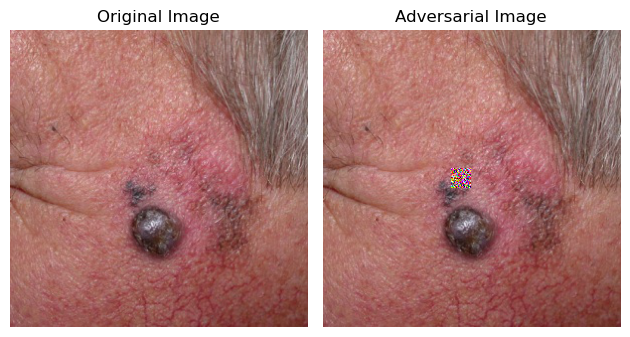

In [16]:
filepath = f"{root}data/ede3cf4179d6e3de2764edecc494c118.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.7
patch_size=20
attacks.sailency_attack_with_image(model, filepath, true_label, eps, patch_size)

In [17]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.saliency_attack(model, d["filepath"], d["labels"], eps, patch_size))

In [18]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["SM pred"] = adv_pred
test_df["SM pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "SM")

SM Success rate: 0.08564814814814815
SM TN Success rate: 0.07291666666666667
SM FP Success rate: 0.01273148148148148


## Data export for analysis

In [19]:
test_df.to_csv(f"{root}exp/test_df_Fitzpatrick17K_CNN.csv", index=False)